In [387]:
%matplotlib inline

import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 7)

# Cleaning Messy Data

---

## Raw data doesn't exist

A dataset, at best, represents a process under study. However, information is always lost and biases are often introduced between the occurrence of the process and recording the observations in a dataset. A person must decide what relevant measurements to make and implement the instrumentation. These human decisions create a gap between the process under study and the observations being used to study it.

The following terms, previously discussed in relation to the scientific method, describe the core objects of study in data science:
* A **data generating process (DGP)** is the underlying, real-world mechanism that generates the observed data.
* **Observed data** (creating a dataset) are incomplete artifacts of the data generating process.
* A **(probability) model** is a simplified explanation of the data generating process. The process described using a model is compared to the observed data to judge the quality of the explanation.

**Example:** ...

To make life more difficult, data scientists often find themselves working with already existing datasets created for purposes different than their current interest. In these cases, special care must be taken to understand both what process the dataset represents and how well it represents it. As such, the data scientist should be an ever-skeptical detective attempting to describe the story of how the dataset came to be, including:
1. a rough description of the assumptions on the underlying data generating process,
1. a detailed description of how the DGP came to populate each field in the dataset (the measurements),
1. a detailed description of any data processing and/or storage decisions that affected the values in the dataset.

These descriptions together form the data's **provenance**. 

"Messy data" are deviations from the process being modeled that *are not* due to randomness. Armed with the provenance for a dataset, the data scientist "cleans" the messy data to best reflect the data generating process.

## Data Cleaning

**Definition:** Data cleaning is the process of transforming data into a faithful representation of an underlying data generating process to facilitate subsequent analysis.

A common procedure for data cleaning often involves:
1. Fixing data types so columns reflect the *kind* of data in each field,
1. Resolving ambiguities and inconsistencies in the data,
1. Identifying corrupt or unlikely values for removal, fixing, or declaration as missing.

Each of these procedures will require applying an arsenal of new Pandas methods to the columns of an existing dataset, while storing the result in a cleaned dataset.

### Data types

Datasets are often designed for human consumption, rather than for computation. Thus, a data scientist attempting to simply describe the contents of a dataset must first fix data-type errors. Whenever possible, one should leverage existing dataset documentation (such as a *data dictionary* or a *database schema*) to set the data-types. In the absence of such resources, one must infer the correct types by reasoning about the process that generated the data.

* **Cleaning the data types** of the columns of a dataset involves resolving the data types present in the columns of a dataset with the *kind of data* represented in each column.

Such cleaning is illustrated in the example below.

**Example:** The observations contained in the dataset below consists of each campus of the University of California. These observations derive from the [College Scorecard Dataset](https://collegescorecard.ed.gov/data/). Each observation consists of the follow attributes:
1. COLLEGE_ID: unique ID for each college
1. NAME: name of the institution
1. UNDERGRAD_POP: the size of each university's undergraduate population
1. PCT_FED_LOAN: the percentage of students at the university who took out federal student loans
1. MEDIAN_GRAD_DEBT: the median debt that students hold upon graduation
1. SETTING: the type of environment in which the university is located

In [388]:
uc = pd.read_csv('data/ucschools.csv')
uc

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
0,131200.0,University of California-Berkeley,30574.0,23.73%,$13200,City
1,131300.0,University of California-Davis,30046.0,36.0%,$14000,City
2,131400.0,University of California-Irvine,29295.0,36.4%,$16500,Suburban
...,...,...,...,...,...,...
6,132000.0,University of California-Santa Barbara,22181.0,36.32%,$16300,Suburban
7,132100.0,University of California-Santa Cruz,17577.0,46.41%,$19700,Suburban
8,4127100.0,University of California-Merced,7375.0,50.13%,$19018,Rural


Any attempts to perform an exploratory data analysis on the columns of the `uc` dataset would quickly produce type-errors (verify this yourself!). To assess each field of the `uc` dataset, Pandas provides a DataFrame property `.dtypes` that returns a series with the data type of each column.

The table `uc` contain columns of `float` and `object` data-types. Recall that `object` columns contain mixed data-types and are usually indicative of the presence of `string` values. Determine which data-types in the table match the data-types implied by the kind of attribute each column contains.

In [389]:
uc.dtypes

COLLEGE_ID          float64
NAME                 object
UNDERGRAD_POP       float64
PCT_FED_LOAN         object
MEDIAN_GRAD_DEBT     object
SETTING              object
dtype: object

*COLLEGE_ID Column:* This column is a unique identifier for each university. As there doesn't seem to be a meaningful order to the column, it is likely *nominal*. Since floating-point numbers are subject to rounding errors, representing COLLEGE_ID as a float might change the unique identifier for an observation. Thus, such column should be represented as either an integer-type or string-type. While either choice is faithful to the meaning of the field, storing the values as `int`-types is more space-efficient.

*Remark:* Why are the values float-type in the first place? Data processing programs often incorrectly infer data-types. If a column is purely numeric, the program will assume the column is quantitative in nature.

Transform the type of the column using the `astype` Series method:

In [390]:
uc['COLLEGE_ID'].astype(int)

0     131200
1     131300
2     131400
      ...   
6     132000
7     132100
8    4127100
Name: COLLEGE_ID, Length: 9, dtype: int64

*PCT_FED_LOAN Column:* This column represents a quantitative column, yet the column in Pandas is of `object` type. One can confirm these values are strings by inspecting one of the entries:

In [391]:
ucb_loans = uc.loc[0, 'PCT_FED_LOAN']
ucb_loans, type(ucb_loans)

('23.73%', str)

Because of the presence of the `%` symbol, Pandas doesn't immediately know how to coerce the values of PCT_FED_LOAN to float-type (verify this!). The column requires cleaning first: strip off the `%`, then coerce the remaining number to a float-type. To strip off the `%` characters, use the string methods Pandas provides within its `str` name-space. The cleaning steps are as follows:
1. strip the `%` character off the end of each string using `Series.str.strip`,
1. coerce the remain string to a float using `astype`,
1. convert the percentage (between 0-100) to a proportion (between 0-1).

In [392]:
(
    uc['PCT_FED_LOAN']
    .str.strip('%')
    .astype(float)
    / 100
)

0    0.2373
1    0.3600
2    0.3640
      ...  
6    0.3632
7    0.4641
8    0.5013
Name: PCT_FED_LOAN, Length: 9, dtype: float64

*MEDIAN_GRAD_DEBT Column:* Similarly, the median debt at graduation is a quantitative column being represent as a string-type because of the presence of the `$` character. A similar process translates these formatted strings into float-types:

In [393]:
(
    uc['MEDIAN_GRAD_DEBT']
    .str.strip('$')
    .astype(float)
)

0    13200.0
1    14000.0
2    16500.0
      ...   
6    16300.0
7    19700.0
8    19018.0
Name: MEDIAN_GRAD_DEBT, Length: 9, dtype: float64

*SETTING Column:* This column is ordinal, as there is an ordering of a university's setting by population density. The ordering of the values is:
```
Rural < Suburban < City < Urban
```
There are three options for cleaning an ordinal column, each with advantages and disadvantages. The ordinal column can be left as is, using the given string representation, mapped to integer values reflecting the ordering described above, or encoded using a Pandas `Categorical` data-type.

For example, one can create an explicit integer-encoding by passing a dictionary to the `replace` method:

In [394]:
encoding = {
    'Rural': 0,
    'Suburban': 1,
    'City': 2,
    'Urban': 3
}

uc['SETTING'].replace(encoding)

0    2
1    2
2    1
    ..
6    1
7    1
8    0
Name: SETTING, Length: 9, dtype: int64

Alternatively, Pandas has a `categorical` data-type that does this conversion automatically.  However, a categorical data-type representing an ordinal column must have the order explicitly defined:

In [395]:
values = ['Rural', 'Suburban', 'City', 'Urban'] # with order!
setting_dtype = pd.CategoricalDtype(categories=values, ordered=True)
setting_dtype

CategoricalDtype(categories=['Rural', 'Suburban', 'City', 'Urban'], ordered=True)

In [396]:
uc['SETTING'].astype(setting_dtype)

0        City
1        City
2    Suburban
       ...   
6    Suburban
7    Suburban
8       Rural
Name: SETTING, Length: 9, dtype: category
Categories (4, object): [Rural < Suburban < City < Urban]

*UNDERGRAD_POP Column:* This column is quantitative, as arithmetic on this column makes sense. For example, the average or total undergraduate populations across schools represent meaningful quantities. As such, even though the column represents integer counts (students don't come in fractions!), float-types can be considered appropriate, along with integer-types.

Finally, one can combine the cleaning steps above into a new table:

In [397]:
cleaned_uc = (
    pd.DataFrame().assign(
        COLLEGE_ID=uc['COLLEGE_ID'].astype(int),
        NAME=uc['NAME'],
        UNDERGRAD_POP=uc['UNDERGRAD_POP'],
        PCT_FED_LOAN=(uc['PCT_FED_LOAN'].str.strip('%').astype(float) / 100),
        MEDIAN_GRAD_DEBT=uc['MEDIAN_GRAD_DEBT'].str.strip('$').astype(float),
        SETTING=uc['SETTING'].astype(setting_dtype)
    )
)

In [398]:
cleaned_uc

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
0,131200,University of California-Berkeley,30574.0,0.2373,13200.0,City
1,131300,University of California-Davis,30046.0,0.3600,14000.0,City
2,131400,University of California-Irvine,29295.0,0.3640,16500.0,Suburban
...,...,...,...,...,...,...
6,132000,University of California-Santa Barbara,22181.0,0.3632,16300.0,Suburban
7,132100,University of California-Santa Cruz,17577.0,0.4641,19700.0,Suburban
8,4127100,University of California-Merced,7375.0,0.5013,19018.0,Rural


In [399]:
cleaned_uc.dtypes

COLLEGE_ID             int64
NAME                  object
UNDERGRAD_POP        float64
PCT_FED_LOAN         float64
MEDIAN_GRAD_DEBT     float64
SETTING             category
dtype: object

**Example:** Sometimes a column contains values that do not easily coerce to the intended type. For example, suppose the Series given below needs to be represented as a column of float-type:

In [400]:
numbers = pd.Series('1,2,2.5,3 1/4,6 7/8,8.3,9,11,99/3'.split(','))
numbers

0       1
1       2
2     2.5
     ... 
6       9
7      11
8    99/3
Length: 9, dtype: object

Attempting to use `astype(float)` will result in a `ValueError`, as python doesn't know how to convert '3 1/4' to a float. To convert this column to float type, one must write a custom function that handles the case of fractional values.

In [401]:
def convert_mixed_to_float(s):
    '''converts a string representation of an integer,
    decimal, or proper fraction to a float'''
    if '/' not in s:
        return float(s)
    else:
        if ' ' in s:
            whole, frac = s.split(' ')
        else:
            whole, frac = '0', s

        num, denom = frac.split('/')
        return float(whole) + float(num) / float(denom)

In [402]:
numbers.apply(convert_mixed_to_float)

0     1.0
1     2.0
2     2.5
     ... 
6     9.0
7    11.0
8    33.0
Length: 9, dtype: float64

*Remark:* The pandas function `pd.to_numeric(series, errors='coerce')` blindly coerces values of a Series to numeric values. When the keyword argument `errors='coerce'` silently replaces any non-coercible values with a missing value. This often leads to dropping data that never should have been dropped; non-coercible data should be handled with care, as it's often present due to systematic issues with how the data was recorded. If such a function was used on `numbers`, 1/3 of the data would be lost!

#### Summary: Cleaning up data-types

**Quantitative Columns** should be represented with numeric data types (float and integer types). However, float-types should only represent quantitative columns. As float values are subject to precision errors, one can only be guaranteed that a value is represented by a *similar value*. This similarity only makes sense with quantitative data.

**Ordinal data** should be represented with a data type that supports ordering (e.g. string or integer types) and has infinite precision (so the label doesn't change). Three common approaches are outlined below:


1. left as is, using the given string representation.
    - Advantages: easy to interpret the values (they remain unchanged)
    - Disadvantages: the string ordering may not match the ordering of the column; strings are inefficient to store.
1. mapped to integer values, reflecting the ordering of the values of the column (called *integer coding*).
    - Advantages: the ordering of the ordinal values are captured by the integers; integers are efficient to store.
    - Disadvantages: integers obscure what the value originally represented.
1. encoded using a Pandas `Categorical` data-type. 
    - Advantages: stores and orders values as integers, while displaying them as strings.
    - Disadvantages: relatively new feature in Pandas that may not always be available to use.
    
**Nominal data** should be represented by a data type with infinite precision. As the values are merely labels, any change in the values would be an arbitrary change to the values of the column.

### Missing data

While Pandas encodes missing values using the value `NaN`, missing data may appear in a dataset in a variety ways. Different data processing and storage systems may use different conventions (e.g. `NULL`, `None`, `""`) or may disallow missing values entirely. This section focuses on strategies for *identifying* the missing values in a dataset; later, the course confronts the problem of how to handle the identified missing values.

Common examples of 'placeholder' missing values that are not obviously missing at first glance:
1. The integer `0` is a common stand-in for missing values, especially when the value is unlikely to occur in a dataset. For example, someone of age 
1. The integer `-1` is a common stand-in for missing values for columns containing non-negative values. For example, a column containing the "number of children in a family" might use `-1` as a missing value.
1. `1900` and `1970` are common placeholder for missing dates in Excel and UNIX respectively. Each of these conventions picks a time as 'time zero' and stores dates and times as "time elapsed since time zero" (1970 was roughly the year UNIX was created). In this way, these placeholders are both special case of using `0` as a missing value.

**Example:** The fitness tracking app Strava encodes missing location coordinates as `0,0`. This encoding gives the impression of Strava user activity at 0°00'00.0"N+0°00'00.0"E, dubbed [Null Island](https://en.wikipedia.org/wiki/Null_Island). 
* While this is a real location, it's location in the middle of the Atlantic ocean makes it highly unlikely to be a meaningful value.
* The common usage of `0` as a missing value makes it likely that this activity comes from users with their location tracking disabled.

**Example:** The bike sharing company [Bluebikes](https://bluebikes.com) makes bike usage data available for the city of Boston. Plotting the distribution of Bluebikes users' year of birth reveals a large spike of riders born in the year 1969.

![distribution_of_birth](imgs/bike.png)

Is this spike unreasonably large? Or is it possible riders of exactly that age use the bike share service that much more?

Most likely these values are missing values, as 1969 corresponds to the value -1 when encoded as a UNIX time-stamp. More problematic is that there really are riders whose birth year is 1969! In this case, telling apart the missing values from the true values may be difficult.

**Example:** The college scorecard data contains information on many colleges beyond the University of California campuses. The table `colleges` below contains a much larger sample of universities across the United States.

In [403]:
colleges = pd.read_csv('data/colleges.csv')
colleges.sample(5)

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
4261,1005200.0,Jefferson Lewis BOCES-Practical Nursing Program,77.0,68.18%,$7250,Rural
1604,2099700.0,Ross Medical Education Center-Flint,153.0,62.5%,$9500,Suburb
830,1113300.0,College of Eastern Idaho,698.0,34.04%,$9500,Urban
6031,4241500.0,Wave Leadership College,52.0,53.23%,PrivacySuppressed,Urban
4814,3855300.0,Ecclesia College,229.0,51.29%,$16500,Rural


The previous code written for cleaning `MEDIAN_GRAD_DEBT` no longer works in this larger dataset (check this code throws an exception), as some values don't conform to the standard representation of US dollars. Before generalizing the cleaning code to the larger dataset, it's necessary to understand the extent to which these "unusual values" are present.

In [404]:
def check_float(x):
    '''returns true if a value is coercible to a float;
    otherwise returns false'''
    try:
        float(x)
        return True
    except ValueError:
        return False

Print the distribution of values that aren't of the the form `$` followed by a string coercible to a float value:

In [405]:
nonnums = (
    colleges['MEDIAN_GRAD_DEBT']
    .str.strip('$')
    .apply(check_float)
)

colleges.loc[~nonnums, 'MEDIAN_GRAD_DEBT'].value_counts()

PrivacySuppressed    1175
Name: MEDIAN_GRAD_DEBT, dtype: int64

In the larger dataset, the only value that doesn't represent dollar amounts is 'PrivacySuppressed'. The meaning of this value is explained in the [dataset documentation](https://collegescorecard.ed.gov/data/documentation/):

> any data not reported in order to protect an individual's privacy are shown as PrivacySuppressed.

Thus, it seems reasonable to interpret this value as a missing value and replace it with NULL.

In [406]:
def median_grad_debt_cleaner(ser):
    return ser.replace('PrivacySuppressed', np.NaN).str.strip('$')

In [407]:
colleges_cleaned = colleges.agg(csc_cleaning_map)

In [409]:
colleges_cleaned

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
0,100200,Alabama A & M University,4824.0,0.7697,32750.0,Urban
1,105200,University of Alabama at Birmingham,12866.0,0.5207,21833.0,Urban
2,2503400,Amridge University,322.0,0.8741,22890.0,Urban
...,...,...,...,...,...,...
6175,4106301,Palm Beach Academy of Health & Beauty-Distinct...,5.0,0.0714,6333.0,NaN
6176,295600,Piedmont International University,336.0,0.4847,12498.0,Urban
6177,4250501,National Personal Training Institute-Tampa,32.0,0.2982,NaN,NaN


### Unfaithful data

The provenance of a dataset, from a real-world event to a dataset displayed in a notebook, is often long and complicated.  However, for this data to be of any use, one must assess how well it captures the "reality" it's meant to describe. Once a dataset is properly typed, it should be assessed for its faithfulness to the data generating process.

Generally, such an assessment involves asking if the data contain unrealistic or "incorrect" values? For example:
- Are there dates in the future for events that occurred the past?
- Are there locations in the dataset that don't exist?
- Are there negative counts? (is that a missing value?)
- Are names misspelled? Do single names have variants such as nicknames?
- Are there unreasonably large outliers?

Assessing for faithfulness involves being skeptical of the data known data provenance and doing research into the assumptions on how the data were generated. This assessment generally involves understanding and identifying problems with the data, then attempting to "fix" the problem. How to fix unfaithful data depends on the context:

- Poor quality observations may be dropped if there are very few or sufficient random.
- The likely values might be (approximately) inferable from either researching into data provenance, or from other values in the dataset.
- The source of problem might be fixed through changes in the experimental design, instrumentation, or data collection.

Assessing the faithfulness of the data to the data generating process involves interpreting exploratory data analyses of the attributes. 

**Example:** The 'UNDERGRAD_POP' attribute represents the count of undergraduates at colleges in the dataset. An initial assessment of this attribute involves plotting the distribution of undergraduates and analyzing the values and their proportions:

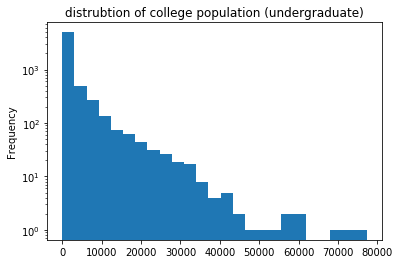

In [410]:
colleges_cleaned['UNDERGRAD_POP'].plot(
    kind='hist', bins=25, logy=True, 
    title='distrubtion of college population (undergraduate)'
);

One interesting observation is how *many* small colleges are in the dataset (note the log-scale!). How small are they? Are the values ever negative?

Plotting colleges with fewer than 1 student reveals six colleges with an undergraduate population of size 0 and no colleges with negative student populations:

In [411]:
# What could this possibly mean?
colleges_cleaned.loc[(colleges_cleaned.UNDERGRAD_POP <= 0)]

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
2702,2154402,Beau Monde College of Hair Design,0.0,0.0962,8973.0,Urban
3107,2188300,Pentecostal Theological Seminary,0.0,0.0000,NaN,Urban
4934,489812,Miami-Jacobs Career College-Springboro,0.0,0.9706,24549.5,NaN
5164,469205,Dorsey Business Schools-Farmington Hills,0.0,1.0000,12986.0,Urban
5574,1091302,Minneapolis Media Institute,0.0,0.8706,14438.0,NaN
6155,405740,National American University-Westwood Teach-Ou...,0.0,0.7027,30223.0,Urban


How might a school have an undergraduate population of size zero? Is this a mistake or reality? 

The answer may be in how the government defines an undergraduate student. It's reasonable to assume that certain schools, like beauty schools or theological seminaries, might service populations outside of an undergraduate program. However, this also brings up the question of why there aren't *more* colleges with an undergraduate population of zero! More research is necessary to understand the reasonableness of a zero value in this column.

**Example:** The college NAME attribute contains the name of each college in the dataset. One might expect this column to uniquely represent a college; computing the head of the empirical distribution of college names reveals this is not the case:

In [412]:
colleges_cleaned.NAME.value_counts()

Stevens-Henager College                   7
Columbia College                          5
McCann School of Business & Technology    5
                                         ..
Greensboro College                        1
Austin Kade Academy                       1
University of California-Davis            1
Name: NAME, Length: 6068, dtype: int64

Among these 7 duplicate 'Stevens-Henager Colleges', are they:
- Truly the same college? (e.g. an error in recording) 
- Are they different, but somehow related? (e.g. different branches of the same school)
- Are they totally unrelated? (e.g. a total coincidence they have the same name).

In [413]:
colleges_cleaned[colleges_cleaned.NAME == 'Stevens-Henager College']

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
3384,367400,Stevens-Henager College,205.0,0.8255,27139.0,NaN
3385,367401,Stevens-Henager College,143.0,0.7831,27139.0,Urban
4521,367403,Stevens-Henager College,563.0,0.7481,27139.0,NaN
4833,367405,Stevens-Henager College,72.0,0.7561,27139.0,Urban
5438,367406,Stevens-Henager College,259.0,0.7057,27139.0,Urban
5576,3120302,Stevens-Henager College,111.0,0.8455,25732.0,Rural
5681,367411,Stevens-Henager College,111.0,0.8281,27139.0,Urban


Since the school statistics differ across the seven colleges, the observations are likely not true duplicates. However, they might be somehow related, as the COLLEGE_IDs are close. More research is necessary to answer this question fully. Next steps might include:
- Retrieving the other attributes from the full college scorecard dataset (e.g. location),
- Looking up the colleges from another source to match the schools in the table to outside information.

### Code Design

The task of data cleaning can be complicated and ad-hoc. The decisions involved in developing data cleaning code often uses domain-specific judgment calls that are far from obvious to someone attempting to understand the process (including the developer themselves, not long after writing the code). Data Scientists should write organized, easy-to-read, easy-to-adapt data cleaning code.

An reasonable approach to writing cleaning code that deals with one column at a time is to: 
1. create a cleaning function for each column,
1. store the cleaning functions in a dictionary, keyed by the name of the column to be cleaned,
1. apply the cleaning functions to the columns using `DataFrame.agg`.

While it may seem overkill to write a separate function for each column, this boilerplate has several advantages over ad-hoc procedural code:
* The docstring of each cleaning function can contain descriptions of both the cleaning itself as well as assumptions made in the development of the cleaning logic.
* Organizing logic into separate functions reduces code complexity as columns are added/changed, or as the cleaning code evolves into more sophisticated logic.
* Applying a dictionary of functions via `agg` allows same code structure to work with parallel processing library such as Spark and Dask.

**Example:** Using this approach, the cleaning code for the College Scorecard data looks as follows:

In [414]:
def college_id_cleaner(ser):
    '''returns identifier COLLEGE_ID as an integer type'''
    return ser.astype(int)

def pct_fed_loan_cleaner(ser):
    '''returns PCT_FED_LOAN as a proportion between 0 and 1.'''
    return ser.str.strip('%').astype(float) / 100

def median_grad_debt_cleaner(ser):
    '''returns MEDIAN_GRAD_DEBT as a float (in USD)'''
    return ser.replace('PrivacySuppressed', np.NaN).str.strip('$').astype(float)

def setting_cleaner(ser):
    '''returns SETTING column as a category data-type
    ordered as RURAL < SUBURBAN < CITY < URBAN'''
    return ser.astype(setting_dtype)

In [415]:
csc_cleaning_map = {
    'COLLEGE_ID': college_id_cleaner,
    'PCT_FED_LOAN': pct_fed_loan_cleaner,
    'MEDIAN_GRAD_DEBT': median_grad_debt_cleaner,
    'SETTING': setting_cleaner
}

csc_cleaning_map = {x: csc_cleaning_map.get(x, lambda x:x) for x in colleges.columns}

In [416]:
colleges.agg(csc_cleaning_map)

,COLLEGE_ID,NAME,UNDERGRAD_POP,PCT_FED_LOAN,MEDIAN_GRAD_DEBT,SETTING
0,100200,Alabama A & M University,4824.0,0.7697,32750,Urban
1,105200,University of Alabama at Birmingham,12866.0,0.5207,21833,Urban
2,2503400,Amridge University,322.0,0.8741,22890,Urban
...,...,...,...,...,...,...
6175,4106301,Palm Beach Academy of Health & Beauty-Distinct...,5.0,0.0714,6333,NaN
6176,295600,Piedmont International University,336.0,0.4847,12498,Urban
6177,4250501,National Personal Training Institute-Tampa,32.0,0.2982,NaN,NaN
